<a href="https://colab.research.google.com/github/volgasezen/di504/blob/main/Lab2/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DI 504: Lab 2
### Using Convolutional Neural Networks for IMDB review sentiment analysis

Contents of this lab originated by [Ben Trevett](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb). It was modified by Arif Ozan Kızıldağ.

If anything here isn't super clear, you can refer to the (older) version above with richer explanations.

After incorporating torch code from Github user [ShalyginaA](https://github.com/ShalyginaA/imdb-sentiment-analysis-with-pytorch/blob/master/imdb_analysis.ipynb), and text preprocessing code from Kaggle user [Lakshmipathi N](https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews) and Özgür Ozan Kılıç's sentiment analysis lab, the lab was updated to work with the most recent version of `torch` and `torchtext`.

In this lab we will analyze IMDB user reviews on films and classify them as having a positive or negative attitude.

The data can be downloaded from [kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [ ]:
import torch
import torchtext

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from utils import *

## Dataset Description
* The dataset consists of 50000 reviews.
* Exactly half is labeled as a positive review, the other half having negative reviews.
* Only highly polarizing reviews were collected.
* A review has a negative label if it has scored $\leq$ 4/10, and positive if it scored $>$ 7/10.
* No movie has more than 30 reviews associated with it.

In [ ]:
imdb_data=pd.read_csv('IMDB Dataset.csv.zip')
print(imdb_data.shape)

# imdb_data['review'] = imdb_data['review'].apply(preprocess)

# imdb_data['sentiment'].replace({'positive':1, 'negative':0}, inplace=True)

(50000, 2)


`preprocess` function from utils gets the text into a more uniform manner.

The preprocessing steps applied involved the following: (adapted from Lakshmipathi N[$^{1}$](#di-504-lab-2) and Özgün Ozan Kılıç)

* HTML tags like `<br>` were removed
* Terms inside square brackets were also removed
* Sentences were broken up into words via `NLTKTokenizer`
* Special characters like `.` `,` and digits were removed
* Words were rid of their suffixes via `PorterStemmer()`
* Stop words like [I, me, and, the, ... ] as well as [movie, character, ... ] were removed

(*Stop words were also processed in a similar fashion prior to the checks for removal*)

Also the string labels were turned to numbers using `pandas.replace` method.

To save time, the preprocessed portion was saved as a npy file, which can be loaded using `np.load`

In [ ]:
# np.save('imdb_data.npy', imdb_data.values)
imdb_data = np.load('imdb_data.npy', allow_pickle=True)

We will again create a vocabulary, but this time we will limit it's size to 30000.

To do this we will get the frequency of each word across the whole dataset, sort the words by their frequency, and take the first 30000 instances.

*(29999 technically, since index 0 is reserved for unknown tokens.)*

In [ ]:
vocab_size = 30000

import itertools
from torchtext.vocab import vocab as vocab_maker
from collections import Counter, OrderedDict

data = imdb_data.to_numpy() if type(imdb_data) == pd.DataFrame else imdb_data

words = list(itertools.chain.from_iterable(data[:,0]))

counter = Counter(words)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples[:vocab_size-1])
vocab = vocab_maker(ordered_dict, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

vocab(['thi', 'desper', 'exampl', 'muhattap'])

[1, 944, 357, 0]

Also instead of trainining embeddings from scratch, we will use pretrained weights from GloVe ([Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/))

We will use their model with 6 billion parameters, and an embedding dimension of 100. (Running this code will download an 800 mb file if it wasn't downloaded before. It might take a while depending on the connection speed.)

When we convert one of our sentences into these vectors, we have an array of shape word length x 100

In [ ]:
from torchtext.vocab import GloVe

global_vectors = GloVe(name='6B', dim=100)
global_vectors.get_vecs_by_tokens(data[0,0]).numpy()

array([[-0.22557 ,  0.49418 ,  0.4861  , ..., -0.45744 ,  0.49646 ,
         0.34906 ],
       [-0.74902 , -0.19963 ,  0.24901 , ..., -0.32662 ,  0.31207 ,
         0.58199 ],
       [-0.21568 ,  0.21229 ,  0.17246 , ..., -0.87301 , -0.1901  ,
        -0.55754 ],
       ...,
       [-0.31036 , -0.18006 ,  0.80064 , ..., -0.5341  ,  0.16042 ,
         0.15427 ],
       [-0.27313 ,  0.53893 ,  0.5334  , ...,  0.14543 , -0.30142 ,
         0.12638 ],
       [-0.48104 ,  0.025006,  0.36128 , ...,  0.18845 ,  1.2672  ,
        -0.12581 ]], dtype=float32)

We need to process our raw data further for the model to accept it. The Collator class defined below (adapted from ShalyginaA[$^{1}$](#di-504-lab-2)) has a collate function which will handle each batch. Look inside the code block to get an idea about what each part does.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Collator:
    def __init__(self, pad_idx):
        # value which will fill the empty space left for a batch
        # when a sentence has more words than others
        self.pad_idx = pad_idx

    def collate(self, batch):
        texts, labels = zip(*batch)

        # words are turned into their vocabulary index
        texts = [torch.tensor(vocab(x)) for x in texts]
        # empty space is padded here, and batch dim is made the first
        texts = torch.nn.utils.rnn.pad_sequence(texts, padding_value=self.pad_idx, batch_first=True)

        labels = torch.tensor(labels)

        # move tensors to device, cuda or cpu
        return texts.to(device), labels.to(device)

We can set seeds for the random number generators in torch using the first 3 lines below:

torch.manual_seed will mostly control stuff outside the model description, (given it is defined in the gpu) like `random_split` in this case.

Setting seeds will allow you to have reproducible code blocks and codebases, but usually for scientific research you would run experiments with different splits and model initiations and report the distribution of performance metrics across experiments.

In [ ]:
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

from torch.utils.data import random_split

data = sorted(data, key=lambda x: len(x[0]))

train_set, valid_set = random_split(data, lengths=[0.8,0.2])
next(iter(train_set))

array([list(['five', 'year', 'prison', 'toni', 'le', 'stphanoi', 'jean', 'servai', 'meet', 'hi', 'dearest', 'friend', 'jo', 'carl', 'mhner', 'italian', 'mario', 'ferrati', 'robert', 'manuel', 'invit', 'toni', 'steal', 'coupl', 'jewel', 'showwindow', 'famou', 'jewelri', 'mappin', 'webb', 'ltd', 'declin', 'toni', 'find', 'hi', 'former', 'girlfriend', 'mado', 'mari', 'sabouret', 'becam', 'lover', 'gangster', 'owner', 'nightclub', 'l', 'ge', 'loui', 'grutter', 'pierr', 'grasset', 'humili', 'beat', 'back', 'take', 'jewel', 'call', 'jo', 'mario', 'propos', 'burglari', 'safe', 'jewelri', 'invit', 'italian', 'specialist', 'safe', 'eleg', 'wolf', 'cesar', 'perlo', 'vita', 'join', 'team', 'plot', 'perfect', 'heist', 'success', 'plan', 'juan', 'cesar', 'make', 'thing', 'go', 'wrong', 'give', 'valuabl', 'ring', 'hi', 'mistress', 'du', 'rififi', 'chez', 'le', 'homm', 'magnific', 'filmnoir', 'certainli', 'among', 'best', 'seen', 'screenplay', 'ha', 'credibl', 'support', 'awesom', 'direct', 'jule', '

Now that we have our dataset as an iterable object, we can wrap the DataLoader structure using the collate_fn.

In [ ]:
pad_idx = 0
collator = Collator(pad_idx)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size,
                                            shuffle = False,
                                            collate_fn = collator.collate
                                          )

valid_loader = torch.utils.data.DataLoader(valid_set,
                                            batch_size,
                                            shuffle = False,
                                            collate_fn = collator.collate
                                          )

next(iter(train_loader))

(tensor([[ 685,   57,  767,  ...,    0,    0,    0],
         [ 375,    6,    2,  ...,    0,    0,    0],
         [ 348,  111, 7852,  ...,    0,    0,    0],
         ...,
         [   1,   19,   30,  ...,    0,    0,    0],
         [3609, 5050,  471,  ...,    0,    0,    0],
         [ 358,  883,  440,  ...,    0,    0,    0]], device='cuda:0'),
 tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
         0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0'))

As you can see, we have vocabulary indices of words for each sentence. Sentences end with 0 because we cannot have a 2d tensor with differing number of length of 1d tensors.

We also have the sentiment for each sentence. (1 = Positive, 0 = Negative)

## Conv1D and Conv2D

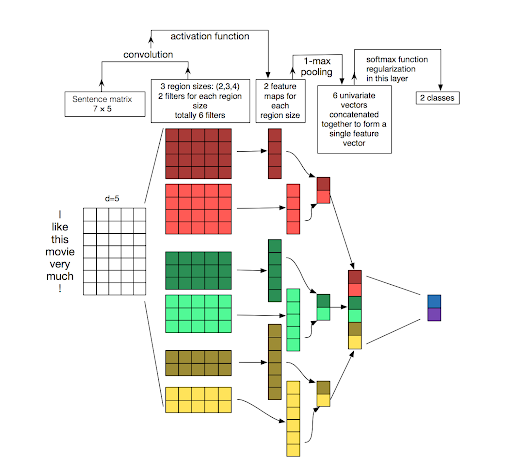

If you previously worked with CNN’s with machine vision tasks, this part sould seem similar to you. In input we have word embeddings which is essentially 2-dimensional array like images. Difference from machine vision tasks our convolutional filter shapes. Because taking part of the word vector is meaningless, our filters will span the whole size of the embeddings. After passing our corpus from different filters we will concatenate them and pass through a linear layer to obtain desired dimensions. Figure above shows a convolutional network with 6 different filters.

In PyTorch there are few different convolutional layer architectures. You maybe familiar with `Conv2D` module from image processing tasks. Because our text input is one dimensional array, we can also use `Conv1D`. Firstly let’s see the differences between these two modules.

`Conv1D` module takes 1 or 2 dimensional array as input. `in_channels` parameter is for depth of the 2nd dimension. `kernel_size` parameters determines sizes of the kernel and `out_channels` parameter determines how many filters will be used. Example below uses 2 different filters with 2 kernel size.

In [ ]:
embedding = nn.Embedding(10, 3)
dum= torch.tensor([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[2,5,6,2,5]])
x= embedding(dum)
print(dum.shape)
print(x.shape)
print(x.transpose(1,2).shape) # if we didnt have batches we could have used rot90()
cvd1 = nn.Conv1d(in_channels=3, out_channels=2,kernel_size=2)
print(cvd1(x.transpose(1,2)).shape)

 torch.Size([6, 5]) <br>
 torch.Size([6, 5, 3]) <br>
 torch.Size([6, 3, 5]) <br>
 torch.Size([6, 2, 4]) <br>

On the other hand `Conv2D` module takes 2 or 3 dimensional arras as input. `in_channels` parameter is for depth of the 3rd dimension. `kernel_size` parameters determines sizes of the kernel and `out_channels` parameter determines how many filters will be used. Example below uses 3 different filters with 2x3 size.

In [ ]:
embedding = nn.Embedding(10, 3)
dum= torch.tensor([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[2,5,6,2,5]])
x= embedding(dum)
print(dum.shape)
print(x.shape)
print(x.unsqueeze(1).shape)
cvd1 = nn.Conv2d(in_channels=1, out_channels=2,kernel_size=(2,3))  # in kernel size 2x3, 3 is the embedding dimension
cvd1(x.unsqueeze(1)).shape

torch.Size([6, 5]) <br>
torch.Size([6, 5, 3]) <br>
torch.Size([6, 1, 5, 3]) <br><br>
torch.Size([6, 2, 4, 1]) <br>

### Helper functions and training loop

In [ ]:
def accuracy(preds, y):
    """ Return accuracy per batch. """
    correct = (torch.round(torch.sigmoid(preds)) == y).float()
    return correct.sum() / len(correct)

def epoch_time(start_time, end_time):
    '''Track training time. '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, iterator, optimizer, criterion):
    '''Train the model with specified data, optimizer, and loss function. '''
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for text, label in iterator:

        # reset the gradients to not accumulate them
        optimizer.zero_grad()

        predictions = model(text).squeeze(1)

        loss = criterion(predictions, label.float())
        acc = accuracy(predictions, label)

        # backpropogate and calculate gradients for each parameter
        loss.backward()

        # using the learning rate and the gradient for parameters update each parameter
        optimizer.step()

        # record accuracy and loss, return average over batch
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    '''Evaluate model performance. '''
    epoch_loss = 0
    epoch_acc = 0

    # Turm off dropout while evaluating
    model.eval()

    # No need to backprop in eval
    with torch.no_grad():

        for text, label in iterator:

            predictions = model(text).squeeze(1)

            loss = criterion(predictions, label.float())
            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Training and evaluation loops were written as functions, for ease of access during multi-epoch training. Notice how on the training function we set model to "train mode", and for the evaluation one model is set to "eval mode".

## 1D Convolutional Neural Network Definition

Notice how the convolutions with different filter sizes will be done in parallel using nn.ModuleList. Result of each convolution will be concatenated after the pooling layer. As words were already turned into high representations via GloVe, we might not need a deep convolutional layer for this task.

In [ ]:
from torch import nn
import torch.nn.functional as F

class CNN_1D(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, vector_size, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        # Create word embeddings from the input words
        self.embedding = nn.Embedding(vocab_size, vector_size,
                                      padding_idx = pad_idx)

        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = vector_size,
                                              out_channels = n_filters,
                                              kernel_size = fs)
                                    for fs in filter_sizes])

        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        # Drop some of the nodes to increase robustness in training
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        '''Forward path of the network.'''
        # Get word embeddings and format them for convolutions
        embedded = self.embedding(text).transpose(1,2)

        # Perform convolutions and apply relu activation
        conved = [F.relu(conv(embedded)) for conv in self.convs]

        # Pooling layer will reduce the sentence into 5 1x100 vectors
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Dropout layer to prevent memorization
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.linear(cat)

Model hyperparameters are defined below:

In [ ]:
# vocab_size defined above as 30000

embed_dim = 100 # Vector size (lower-dimensional repr. of each word)
n_filters = 100 # Number of filters

filter_sizes = [1, 2, 3, 4, 5] # N-grams that we want to analuze using filters

output_dim = 1 # Output of the linear layer (prob of a negative review)

dropout = 0.5 # Proportion of units to drop in each iteration

unk_idx = 0 # Zero the initial weights of the UNKnown and padding tokens.
pad_idx = 0

Instead of retraining the embedding layer from scratch, we will utilize GloVe embeddings instead.

The vectors we downloaded from GloVe will be used to convert our vocabulary into a look-up table of embeddings. This will replace the default random weights of the embedding layer in our model.

Notice how the first element is again set to zeros since it represents unknown words.

In [ ]:
word_list = sorted_by_freq_tuples[:vocab_size-1]

vocab_vectors = torch.cat([global_vectors.get_vecs_by_tokens(x[0]) for x in word_list]).reshape(-1,embed_dim)
vocab_vectors = torch.cat([torch.zeros(1,embed_dim), vocab_vectors], axis=0)
vocab_vectors.shape

torch.Size([30000, 100])

Here the model is initialized with the defined hyperparameters. Notice how the embedding layer is frozen by setting its' `requires_grad` field to false. This will improve the model training time quite a bit since we won't update the 3 million weights inside, and only focus on the kernel weights (5x6/2 = 15) and the linear layer weights (500x1).

In [ ]:
# Initialize model
model = CNN_1D(vocab_size, embed_dim,
            n_filters, filter_sizes,
            output_dim, dropout, pad_idx)

# load pre-trained weights from glove and freeze them
model.embedding.weight.data.copy_(vocab_vectors.to('cuda'))
model.embedding.requires_grad = False

model.embedding.weight.data[unk_idx] = torch.zeros(embed_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embed_dim)
model = model.to(device)

For the optimizer, [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) is used this time. It is more efficient than SGD in reaching the loss minima for many domains.

We again have learning rate scheduling. It will reduce the learning rate by a factor of 10 each epoch by using `scheduler.step()` in the final training loop.

BCE stands for binary cross entropy, and is the standard loss function for any binary classification problem (where classes are nominal in nature). `BCEWithLogitsLoss` is a version of BCE that combines the sigmoid activation, allowing us to not use the sigmoid in the model definition. This is argued to be slightly faster, but overall not a huge deal.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Network optimizer

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1) # Learning rate scheduler

criterion = nn.BCEWithLogitsLoss() # Loss function

## Training loop in action

Bringing everything together is the loop below. It will call the train and evaluate functions defined above for 10 epochs. We will also track accuracy and loss for each epoch and print them out to track the model while its learning.

In [ ]:
import time
# Training loop
n_epochs = 10

best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

for epoch in range(n_epochs):

    # Calculate training time
    start_time = time.time()

    # Get epoch losses and accuracies
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    scheduler.step()

    # Save training metrics
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'CNN-model.pt')

    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 0m 19s
	Train Loss: 0.434 | Train Acc: 79.20%
	 Val. Loss: 0.310 |  Val. Acc: 87.02%
Epoch:  2 | Epoch Time: 0m 11s
	Train Loss: 0.281 | Train Acc: 88.18%
	 Val. Loss: 0.301 |  Val. Acc: 87.47%
Epoch:  3 | Epoch Time: 0m 11s
	Train Loss: 0.266 | Train Acc: 89.09%
	 Val. Loss: 0.300 |  Val. Acc: 87.63%
Epoch:  4 | Epoch Time: 0m 11s
	Train Loss: 0.264 | Train Acc: 89.30%
	 Val. Loss: 0.300 |  Val. Acc: 87.62%
Epoch:  5 | Epoch Time: 0m 11s
	Train Loss: 0.262 | Train Acc: 89.24%
	 Val. Loss: 0.300 |  Val. Acc: 87.63%
Epoch:  6 | Epoch Time: 0m 11s
	Train Loss: 0.263 | Train Acc: 89.13%
	 Val. Loss: 0.300 |  Val. Acc: 87.63%
Epoch:  7 | Epoch Time: 0m 11s
	Train Loss: 0.263 | Train Acc: 89.06%
	 Val. Loss: 0.300 |  Val. Acc: 87.63%
Epoch:  8 | Epoch Time: 0m 11s
	Train Loss: 0.263 | Train Acc: 89.20%
	 Val. Loss: 0.300 |  Val. Acc: 87.63%
Epoch:  9 | Epoch Time: 0m 11s
	Train Loss: 0.263 | Train Acc: 89.27%
	 Val. Loss: 0.300 |  Val. Acc: 87.63%
Epoch: 10 | Epoch T

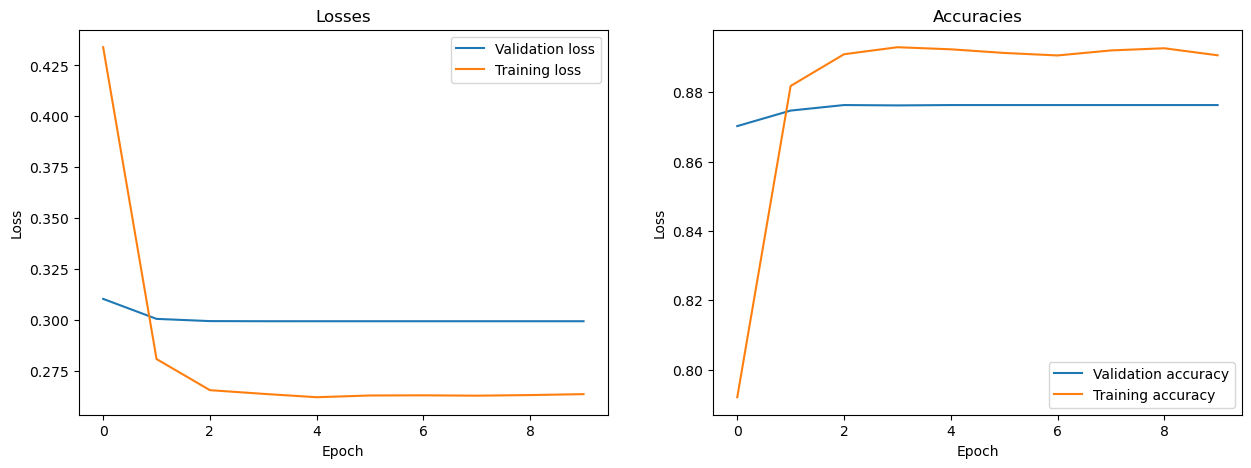

In [ ]:
# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(val_loss, label='Validation loss')
ax[0].plot(tr_loss, label='Training loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_acc, label='Validation accuracy')
ax[1].plot(tr_acc, label='Training accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

As you can see for this configuration epoch size of 10 was a bit too much, as the model stopped improving past epoch 4. Still, if we didn't set a learning rate scheduler the model would be on track to overfit the training set, while having slightly reduced accuracy for the validation set.

## Evaluation

In [ ]:
def sentiment(model, sentence, min_len = 5):
    '''Predict user-defined review sentiment.'''
    model.eval()
    tokenized = preprocess(sentence)
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    # Map words to word embeddings
    indexed = vocab(tokenized)

    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    # Get predicitons
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

reviews = ['This is the best movie I have ever watched!',
           'This is an okay movie',
           'This was a waste of time! I hated this movie.']
scores = [sentiment(model, review) for review in reviews]
scores

[0.9359662532806396, 0.07170946151018143, 0.007577890530228615]

The model peforms reasonably well in separating obviously good and bad reviews, but struggles when some neuance is thrown in. This is to be expected as the dataset is biased towards extreme reviews, and doesn't have any reviews with a score between 4 and 7.

In [ ]:
tricky_reviews = ['This is not the best movie I have ever watched!',
           'Some would say it is an okay movie, but I found it terrific.',
           'This was a waste of time! I did not like this movie.']
scores = [sentiment(model, review) for review in tricky_reviews]
scores

[0.9359662532806396, 0.32329699397087097, 0.010828480124473572]

When given more words, the model can give more accurate results.

Remember that a rather large chunk of the words are cleaned as they don't carry much semantic meaning, like "would, is, I, it", so the model saw the same exact words for the first review in both cases.

But now the review in the middle prompts the model to give a more appropriate response.

# Try on your own:

* Unfreeze the embedding layer so that GloVe vectors are allowed to adapt to the task at hand
* Disable learning rate scheduling / try different learning rate and gamma combos to see how the network evolves over time
* Use different preprocessing approaches (if you are interested in NLP specifically). You can explore `mark_negation` from `nltk.sentiment.util`, different approaches to get words into their roots like lemmatization (like snowball lemmatizer, but this can take longer to preprocess).

# Further reading:

If you are having trouble understanding the difference between 1D and 2D convolutions, I suggest you have a look at this [stack exchange post](https://stats.stackexchange.com/questions/292751/is-a-1d-convolution-of-size-m-with-k-channels-the-same-as-a-2d-convolution-o/292791) and [Intro to CNN blog post](https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29).

If you want vision based explanations, I can recommend this standford course page on [convolutional networks](https://cs231n.github.io/convolutional-networks/).